In [98]:
import os
import h5py
import numpy as np
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt

In [99]:
data = natsorted(os.listdir("data/trained_models"))
cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
gm_h5 = h5py.File("data/EPInformer/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5")
k5_h5 = h5py.File("data/EPInformer/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5")

In [100]:
gm_cage = cage[["ENSID", "GM12878_CAGE_128*3_sum"]]
k5_cage = cage[["ENSID", "K562_CAGE_128*3_sum"]]

In [ ]:
def decode_and_plot(ensid_folds, h5):
    # Grabs the rows that match the condition we set (negative predictions, error threshold, etc).
    ensid, folds = zip(*ensid_folds)
    bool_df = [gene.decode() in ensid for gene in h5["ensid"]]
    rna_signals = h5["rna"][:][bool_df]

    # Only look at the genes that have a signal.
    filtered_0s = rna_signals[np.any(rna_signals != 0, axis = 1)]
    signal_index = np.where(np.any(rna_signals != 0, axis = 1))[0]
    only_0s_index = np.where(np.all(rna_signals == 0, axis = 1))[0]
    tss_signal = [gene.decode() for gene in h5["ensid"][:][signal_index]]
    tss_no_signal = [gene.decode() for gene in h5["ensid"][:][only_0s_index]]

    print(f"Total Number of Matches: {len(rna_signals)}")
    print(f"Total Matches with >= 1 Non-Zero Value: {len(filtered_0s)}")
    print(f"Percentage of TSSs with No Signal: {(len(rna_signals) - len(filtered_0s)) / len(rna_signals) * 100:.2f}%")

    print(f"Genes w/ Signal: {tss_signal}")
    print(f"Genes w/o Signal: {tss_no_signal}")

    for signal in filtered_0s:
        plt.plot(signal)
    
    return signal_index, only_0s_index

In [102]:
def test_thresholds(dict, h5, conditional_column, thresholds, operand):
    # Grab the ENSIDs that fit our condition.
    for threshold in thresholds:
        if operand == "g":
            ensid_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 3])
        elif operand == "ge":
            ensid_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 3])
        elif operand == "l":
            ensid_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 3])
        elif operand == "le":
            ensid_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 3])
        elif operand == "eq":
            ensid_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 3])

        print(f"Threshold: {threshold}")
        print("Genes per Fold: ")
        for i, c in pd.Series(fold_matches).value_counts().sort_index().items():
            print(f"{i}: {c}")
        signal_index, only_0s_index = decode_and_plot(zip(ensid_matches, fold_matches), h5)
        plt.show()
        plt.clf()

        return signal_index, only_0s_index

In [103]:
results_dict = {}
results_dict["GM12878"] = pd.DataFrame()
results_dict["K562"] = pd.DataFrame()

for file in data:
    df = pd.read_csv(f"data/trained_models/{file}")
    if "GM12878" in file:
        results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    else:
        results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

results_dict["GM12878"] = results_dict["GM12878"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)
results_dict["K562"] = results_dict["K562"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)

print(f"Num Rows (GM12878): {len(results_dict["GM12878"])}")
print(f"Num Rows (K562): {len(results_dict["K562"])}")

Num Rows (GM12878): 28357
Num Rows (K562): 28357


In [104]:
for key in results_dict.keys():
    print(f"{key}: ")
    results_dict[key]["Error"] = abs(results_dict[key]["Pred"] - results_dict[key]["actual"])
    results_dict[key]["Signed Error"] = results_dict[key]["Pred"] - results_dict[key]["actual"]

    print(f"Mean Error per Fold:\n{results_dict[key].groupby("fold_idx")["Error"].mean()}")

    print(f"\nMax Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().max()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmax()}")

    print(f"\nMin Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().min()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmin()}")

    print(f"\nMean Error: {results_dict[key]["Error"].mean()}")

    print(f"\nMax Error: {results_dict[key]["Error"].max()}")

    print(f"\nMin Error: {results_dict[key]["Error"].min()} \n")

gm = results_dict["GM12878"]
k5 = results_dict["K562"]

GM12878: 
Mean Error per Fold:
fold_idx
1     0.481959
2     0.462896
3     0.448480
4     0.401176
5     0.483600
6     0.493191
7     0.453553
8     0.510620
9     0.459719
10    0.482234
11    0.491844
12    0.465200
Name: Error, dtype: float64

Max Error Fold: 0.5106199704772214 at Fold 8

Min Error Fold: 0.4011763194403461 at Fold 4

Mean Error: 0.4721234398075166

Max Error: 4.650927579999999

Min Error: 4.979999999998874e-05 

K562: 
Mean Error per Fold:
fold_idx
1     0.487613
2     0.487481
3     0.509309
4     0.409071
5     0.511217
6     0.462325
7     0.489290
8     0.525177
9     0.510695
10    0.506246
11    0.484115
12    0.508029
Name: Error, dtype: float64

Max Error Fold: 0.5251767962132975 at Fold 8

Min Error Fold: 0.409071202792056 at Fold 4

Mean Error: 0.4940765429518559

Max Error: 4.908513902

Min Error: 1.8000000000073513e-05 



Negative Predictions

GM12878: 
Threshold: 0
Genes per Fold: 
1: 119
3: 1
4: 12
6: 170
8: 32
Total Number of Matches: 334
Total Matches with >= 1 Non-Zero Value: 60
Percentage of TSSs with No Signal: 82.04%
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000240409', 'ENSG00000272438', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000187961', 'ENSG00000187642', 'ENSG00000304119', 'ENSG00000162571', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000107404', 'ENSG00000221978', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197530_1', 'ENSG00000169885', 'ENSG00000067606_1', 'ENSG00000116151_1', 'ENSG00000157873_2', 'ENSG00000157870', 'ENSG00000169717', 'ENSG00000238260', 'ENSG00000078900_1', 'ENSG00000235169', 'ENSG00000169598_1', 'ENSG00000131697', 'ENSG00000158286', 'ENSG00000097021_1', 'ENSG00000041988', 'ENSG00000041988_1', 'ENSG00000007923', 'ENSG00000049245', 'ENSG00000049246', 'ENSG00000049247', 'ENSG00000116285', 'ENSG00000074800_1', 'ENSG00000049239', 'ENSG00000188807

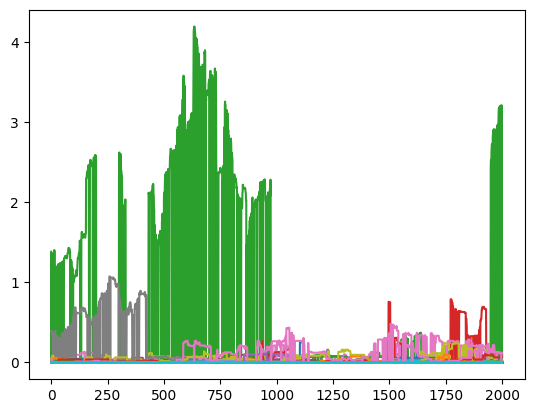

K562: 
Threshold: 0
Genes per Fold: 
1: 3
4: 18
6: 98
9: 33
10: 331
11: 49
Total Number of Matches: 532
Total Matches with >= 1 Non-Zero Value: 108
Percentage of TSSs with No Signal: 79.70%
TSSs w/ Signal: ['ENSG00000107404', 'ENSG00000228594', 'ENSG00000157933_1', 'ENSG00000116151', 'ENSG00000149527_1', 'ENSG00000236423', 'ENSG00000116254', 'ENSG00000116251_1', 'ENSG00000158286', 'ENSG00000116251_2', 'ENSG00000158292', 'ENSG00000097021_2', 'ENSG00000069812', 'ENSG00000187017', 'ENSG00000187017_2', 'ENSG00000041988', 'ENSG00000171735_1', 'ENSG00000049249', 'ENSG00000116288', 'ENSG00000116288_1', 'ENSG00000227634', 'ENSG00000142599_1', 'ENSG00000074800_1', 'ENSG00000142583_1', 'ENSG00000142583_3', 'ENSG00000180758', 'ENSG00000228526', 'ENSG00000228526_1', 'ENSG00000228526_2', 'ENSG00000171621', 'ENSG00000130939', 'ENSG00000160049', 'ENSG00000142655', 'ENSG00000230337', 'ENSG00000132879', 'ENSG00000116663', 'ENSG00000116670', 'ENSG00000177000_1', 'ENSG00000011021', 'ENSG00000116688_2', '

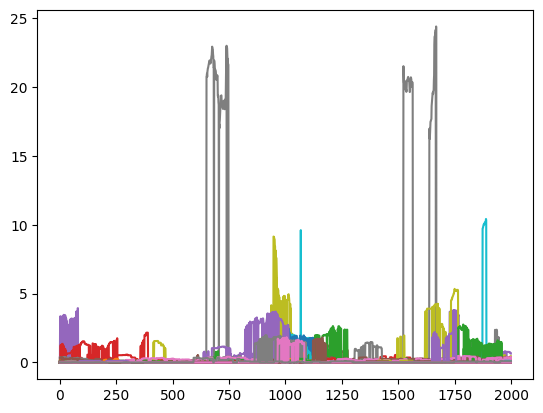

<Figure size 640x480 with 0 Axes>

In [105]:
print("GM12878: ")
gm_neg_pred_signal, gm_neg_pred_no_signal = test_thresholds(gm, gm_h5, "Pred", [0], "l")

print("K562: ")
k5_neg_pred_signal, k5_neg_pred_no_signal = test_thresholds(k5, k5_h5, "Pred", [0], "l")

Low Errors

In [106]:
gm["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.005350
0.05    0.027846
0.10    0.057697
Name: Error, dtype: float64

In [107]:
k5["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.005069
0.05    0.025330
0.10    0.051010
Name: Error, dtype: float64

GM12878: 
Threshold: 0.001
Genes per Fold: 
1: 8
2: 3
3: 6
4: 2
6: 5
7: 2
8: 3
10: 2
11: 1
12: 1
Total Number of Matches: 33
Total Matches with >= 1 Non-Zero Value: 15
Percentage of TSSs with No Signal: 54.55%
TSSs w/ Signal: ['ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000186891', 'ENSG00000176022']
TSSs w/o Signal: ['ENSG00000310526', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187583', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186827', 'ENSG00000078808']


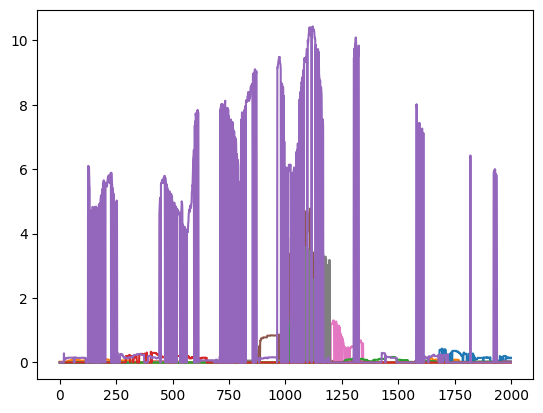

K562: 
Threshold: 0.001
Genes per Fold: 
1: 1
2: 1
3: 1
4: 14
5: 2
6: 10
7: 4
8: 1
9: 4
10: 13
11: 7
Total Number of Matches: 58
Total Matches with >= 1 Non-Zero Value: 25
Percentage of TSSs with No Signal: 56.90%
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000272438', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000131591', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000127054', 'ENSG00000242485', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000272106']
TSSs w/o Signal: ['ENSG00000225630', 'ENSG00000237973', 'ENSG00000198744', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000237330', 

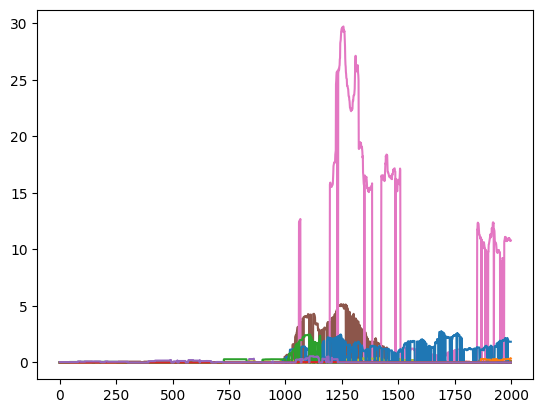

<Figure size 640x480 with 0 Axes>

In [108]:
print("GM12878: ")
gm_low_error_signal, gm_low_error_no_signal = test_thresholds(gm, gm_h5, "Error", [0.001, 0.01, 0.1], "l")

print("K562: ")
k5_low_error_signal, k5_low_error_no_signal = test_thresholds(k5, k5_h5, "Error", [0.001, 0.01, 0.1], "l")

High Errors

In [109]:
gm["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.079988
0.95    1.487276
0.99    2.266954
Name: Error, dtype: float64

In [110]:
k5["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.176917
0.95    1.627252
0.99    2.358835
Name: Error, dtype: float64

GM12878: 
Threshold: 1
Genes per Fold: 
1: 365
2: 283
3: 220
4: 160
5: 289
6: 284
7: 223
8: 358
9: 287
10: 338
11: 224
12: 278
Total Number of Matches: 3309
Total Matches with >= 1 Non-Zero Value: 2560
Percentage of TSSs with No Signal: 22.64%
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000175756', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG0000

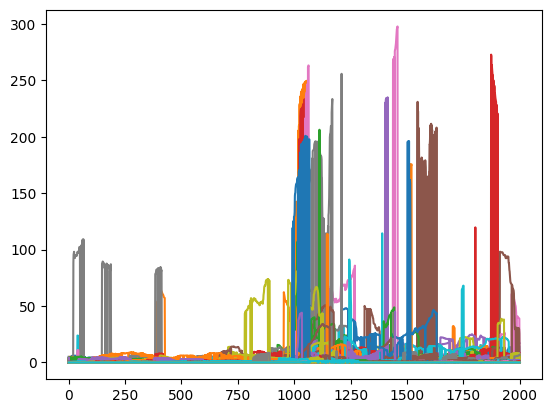

K562: 
Threshold: 1
Genes per Fold: 
1: 358
2: 344
3: 267
4: 179
5: 296
6: 267
7: 239
8: 352
9: 402
10: 447
11: 302
12: 373
Total Number of Matches: 3826
Total Matches with >= 1 Non-Zero Value: 2689
Percentage of TSSs with No Signal: 29.72%
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000221978', 'ENSG000

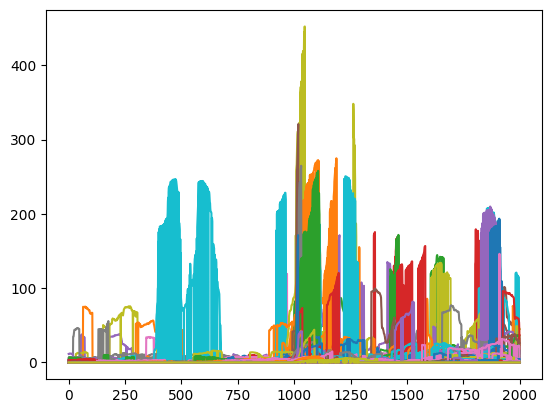

<Figure size 640x480 with 0 Axes>

In [111]:
print("GM12878: ")
gm_high_error_signal, gm_high_error_no_signal = test_thresholds(gm, gm_h5, "Error", [1, 1.5, 2], "g")

print("K562: ")
k5_high_error_signal, k5_high_error_no_signal = test_thresholds(k5, k5_h5, "Error", [1, 1.5, 2], "g")

Overestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 1484
2: 1219
3: 763
4: 613
5: 1070
6: 1224
7: 1030
8: 1524
9: 1066
10: 1433
11: 681
12: 1085
Total Number of Matches: 13192
Total Matches with >= 1 Non-Zero Value: 8456
Percentage of TSSs with No Signal: 35.90%
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186827', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000224870', 'ENSG00000242485', 'ENSG000002350

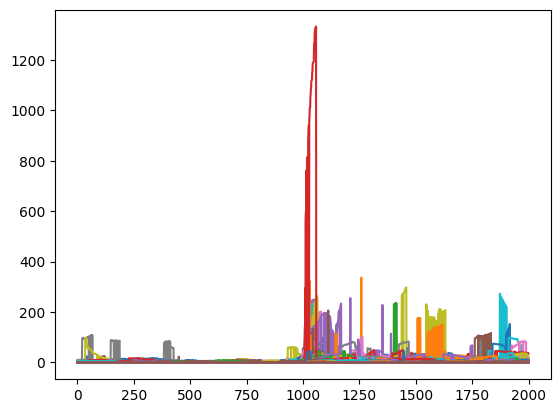

K562
Threshold: 0
Genes per Fold: 
1: 916
2: 903
3: 439
4: 676
5: 720
6: 901
7: 809
8: 1154
9: 1258
10: 1526
11: 1132
12: 1279
Total Number of Matches: 11713
Total Matches with >= 1 Non-Zero Value: 6966
Percentage of TSSs with No Signal: 40.53%
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000240409', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000162571', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000272106', 'ENSG00000197530_1', 'ENSG0

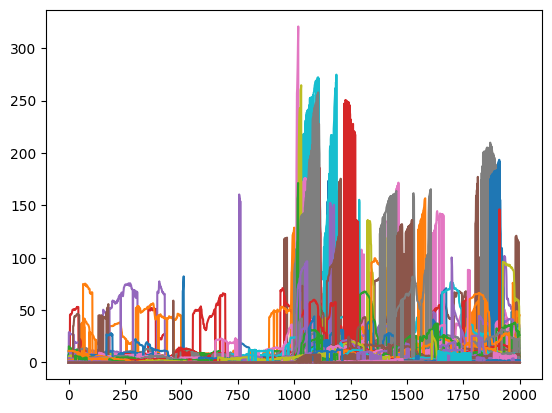

<Figure size 640x480 with 0 Axes>

In [112]:
print("GM12878: ")
gm_over_signal, gm_over_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "l")

print("K562")
k5_over_signal, k5_over_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "l")

Underestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 1302
2: 1374
3: 1174
4: 976
5: 1253
6: 765
7: 1059
8: 1078
9: 1432
10: 1559
11: 1578
12: 1615
Total Number of Matches: 15165
Total Matches with >= 1 Non-Zero Value: 8684
Percentage of TSSs with No Signal: 42.74%
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000240409', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000131584', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000175756', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000160072', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000160075_

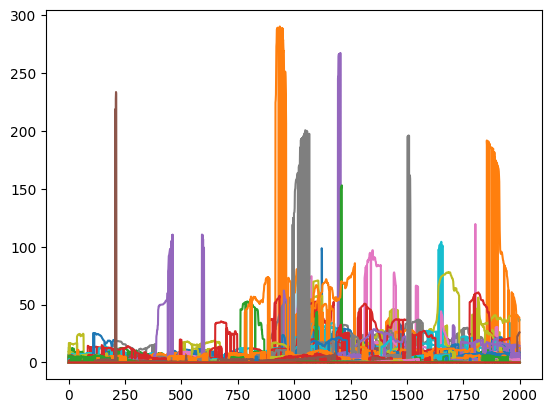

K562
Threshold: 0
Genes per Fold: 
1: 1870
2: 1690
3: 1498
4: 913
5: 1603
6: 1088
7: 1280
8: 1448
9: 1240
10: 1466
11: 1127
12: 1421
Total Number of Matches: 16644
Total Matches with >= 1 Non-Zero Value: 8454
Percentage of TSSs with No Signal: 49.21%
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000175756', 'ENSG00000224870', 'ENSG00000179403', 'ENSG00000215915', 

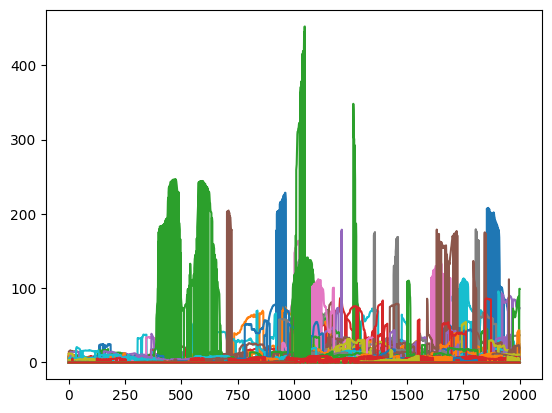

<Figure size 640x480 with 0 Axes>

In [113]:
print("GM12878: ")
gm_under_signal, gm_under_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "g")

print("K562")
k5_under_signal, k5_under_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "g")

Worst Errors (Over Expressed)

In [114]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Signed Error"] = pd.to_numeric(over_df_gm["Signed Error"])
    over_df_5_worst_gm = over_df_gm.nlargest(5, columns=["Signed Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Signed Error"] = pd.to_numeric(over_df_k5["Signed Error"])
    over_df_5_worst_k5 = over_df_k5.nlargest(5, columns=["Signed Error"])

print("GM12878: ")
display(over_df_5_worst_gm)

print("K562: ")
display(over_df_5_worst_k5)

GM12878: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
9052,ENSG00000092199,4.277305,0.0,5,NaN,4.277305,4.277305
2178,ENSG00000160752,3.078199,0.0,1,NaN,3.078199,3.078199
23933,ENSG00000107862,2.964468,0.0,11,NaN,2.964468,2.964468
24073,ENSG00000156650_2,2.888517,0.0,11,NaN,2.888517,2.888517
19575,ENSG00000140259,2.871539,0.0,9,NaN,2.871539,2.871539


K562: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
779,ENSG00000143106,3.387730,0.0,1,2220.680,3.387730,3.387730
1248,ENSG00000266472,3.169929,0.0,1,1100.910,3.169929,3.169929
444,ENSG00000177954,3.154718,0.0,1,17994.400,3.154718,3.154718
802,ENSG00000160072,3.078762,0.0,1,476.576,3.078762,3.078762
262,ENSG00000237491,2.898002,0.0,1,73.276,2.898002,2.898002


GM12878: 


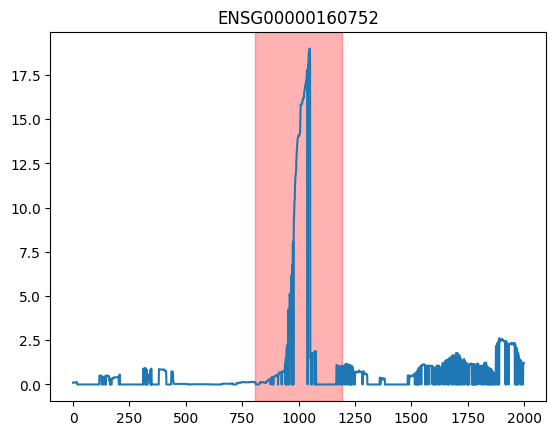

Pred: 3.078199
Actual: 0.0


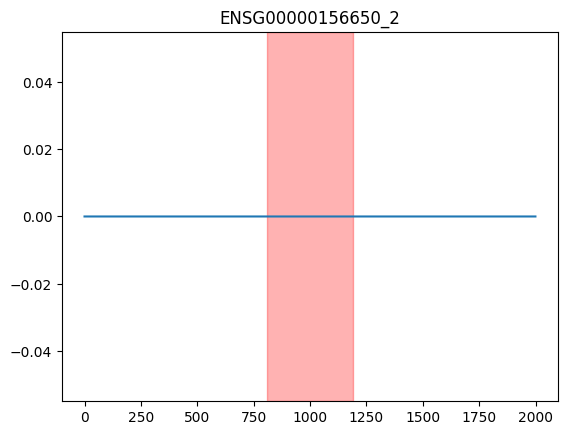

Pred: 2.8885171
Actual: 0.0


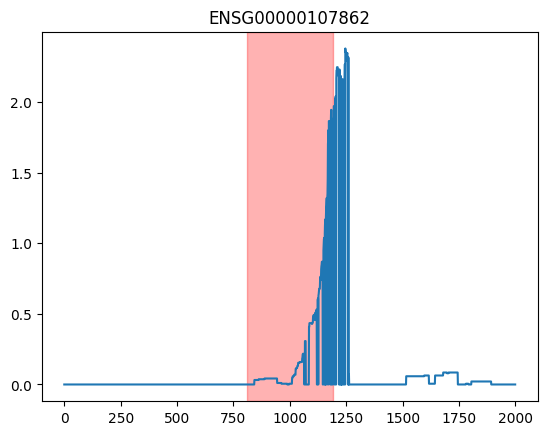

Pred: 2.964468
Actual: 0.0


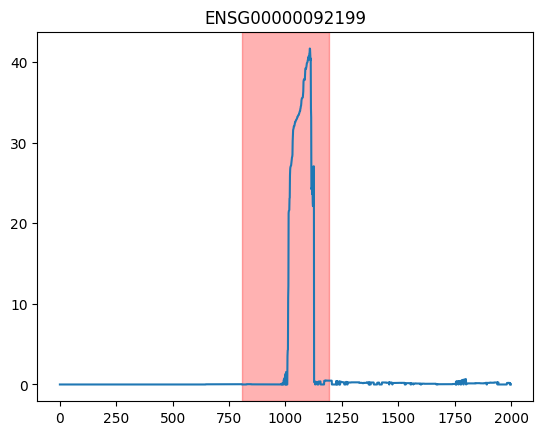

Pred: 4.2773046
Actual: 0.0


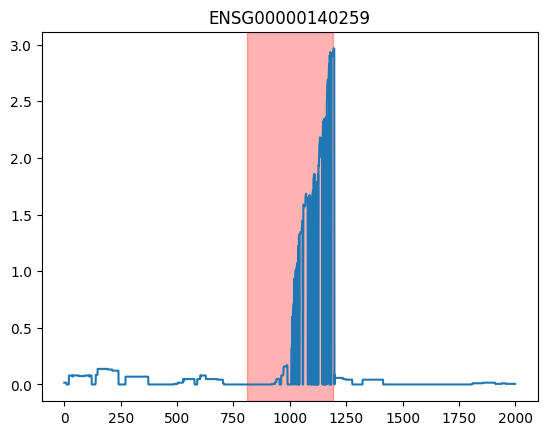

Pred: 2.8715386
Actual: 0.0

K562: 


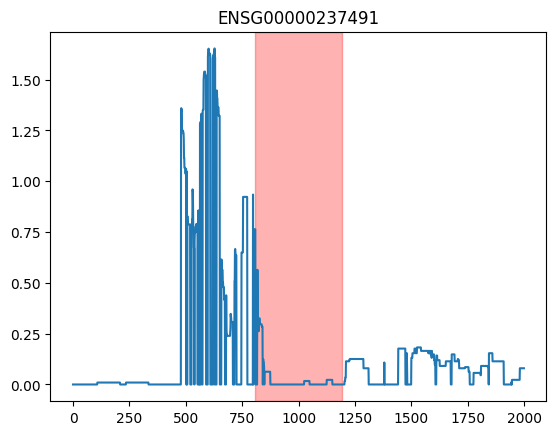

Pred: 2.8980021
Actual: 0.0


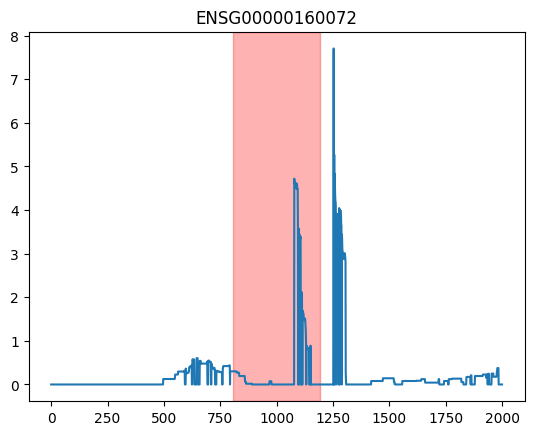

Pred: 3.0787625
Actual: 0.0


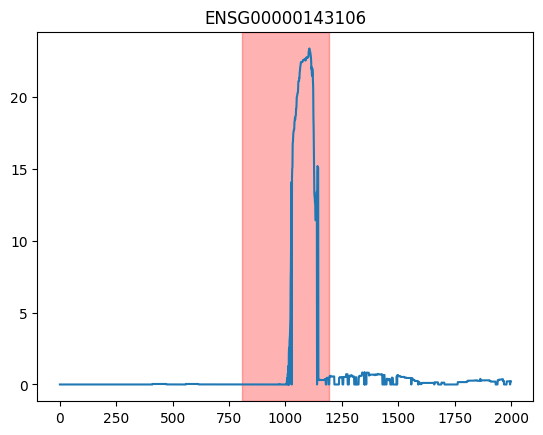

Pred: 3.3877301
Actual: 0.0


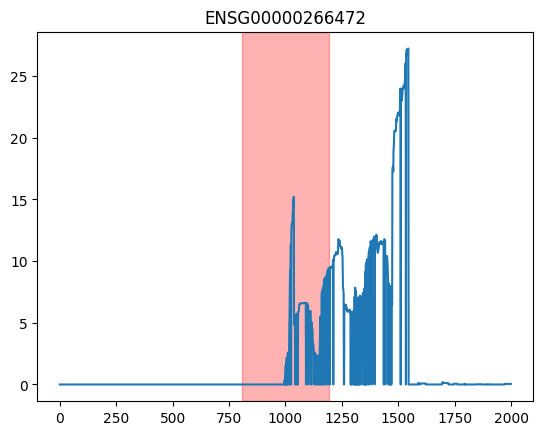

Pred: 3.1699286
Actual: 0.0


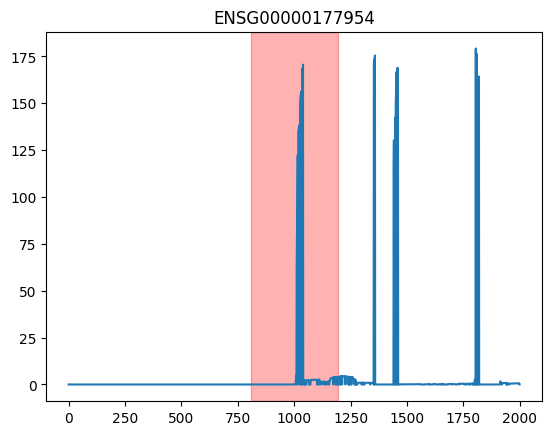

Pred: 3.1547184
Actual: 0.0


In [115]:
# Individual Plots
signal_5_worst_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_over_gm):
    plt.plot(signal_5_worst_over_gm[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.show()

    print(f"Pred: {gm[gm["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {gm[gm["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_over_k5):
    plt.plot(signal_5_worst_over_k5[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.show()

    print(f"Pred: {k5[k5["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {k5[k5["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}")

Worst Errors (Under Expressed)

In [116]:
with pd.option_context("mode.chained_assignment", None):
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Signed Error"] = pd.to_numeric(under_df_gm["Signed Error"])
    under_df_5_worst_gm = under_df_gm.nsmallest(5, columns=["Signed Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Signed Error"] = pd.to_numeric(under_df_k5["Signed Error"])
    under_df_5_worst_k5 = under_df_k5.nsmallest(5, columns=["Signed Error"])

print("GM12878: ")
display(under_df_5_worst_gm)

print("K562: ")
display(under_df_5_worst_k5)

GM12878: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
805,ENSG00000201317,0.032096,4.349751,1,22373.40,4.317656,-4.317656
18619,ENSG00000202538,1.541426,5.662860,9,460107.00,4.121434,-4.121434
532,ENSG00000143185,0.028482,3.915335,1,8227.76,3.886853,-3.886853
17167,ENSG00000251562_2,1.207475,4.923780,8,83902.50,3.716305,-3.716305
15414,ENSG00000199325,0.109371,3.754244,8,5677.64,3.644873,-3.644873


K562: 


,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
15419,ENSG00000196565,1.065716,4.842275,8,NaN,3.776559,-3.776559
16476,ENSG00000213934,1.028399,4.588648,8,NaN,3.560250,-3.560250
18985,ENSG00000174444,1.206376,4.475434,9,36587.7,3.269059,-3.269059
24668,ENSG00000222177,0.058338,3.251373,11,NaN,3.193035,-3.193035
24666,ENSG00000219932,0.068658,3.243274,11,1440.8,3.174616,-3.174616


GM12878: 


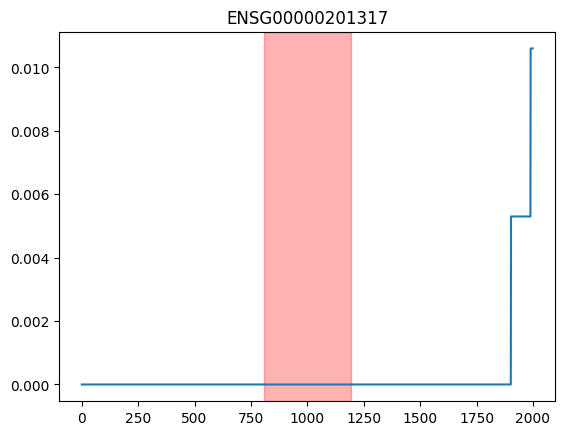

Pred: 0.032095756
Actual: 4.3497515


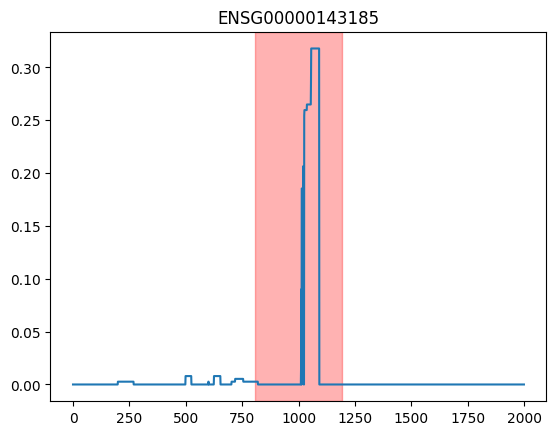

Pred: 0.028481647
Actual: 3.9153345


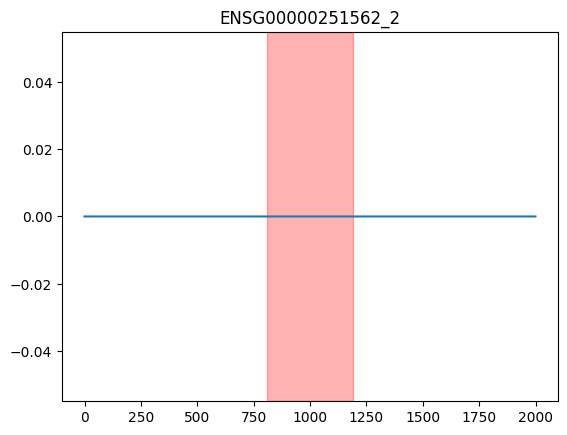

Pred: 1.2074752
Actual: 4.92378


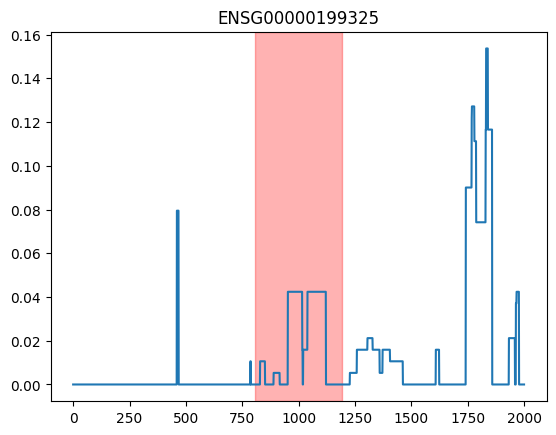

Pred: 0.10937125
Actual: 3.7542443


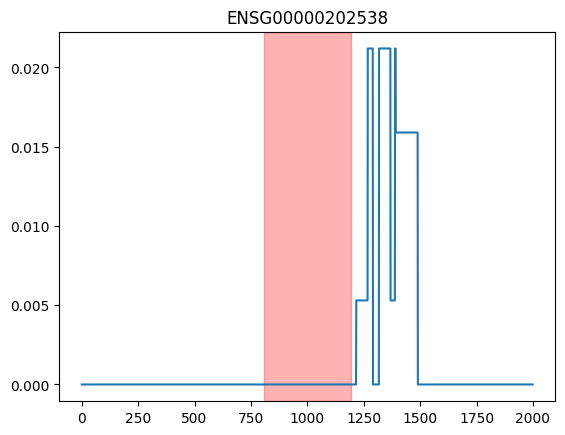

Pred: 1.541426
Actual: 5.66286

K562: 


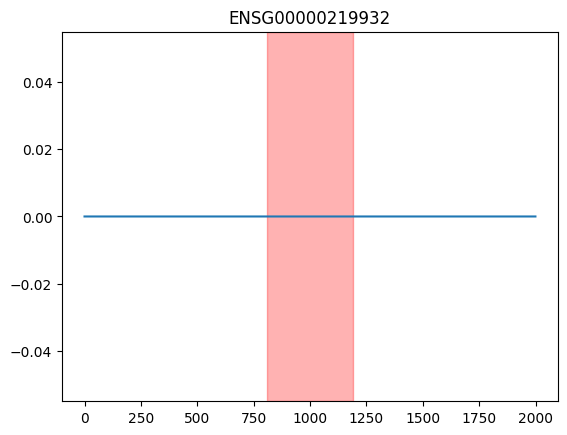

Pred: 0.06865752
Actual: 3.2432737


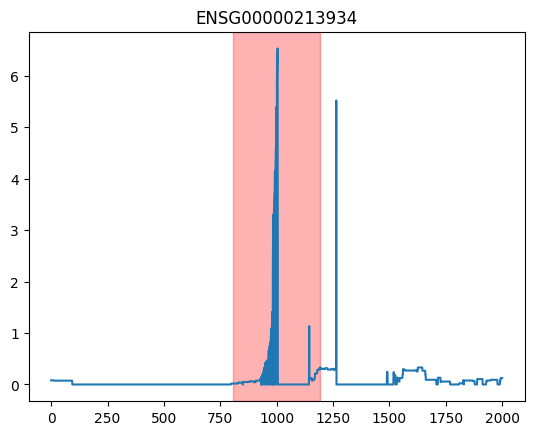

Pred: 1.0283986
Actual: 4.5886483


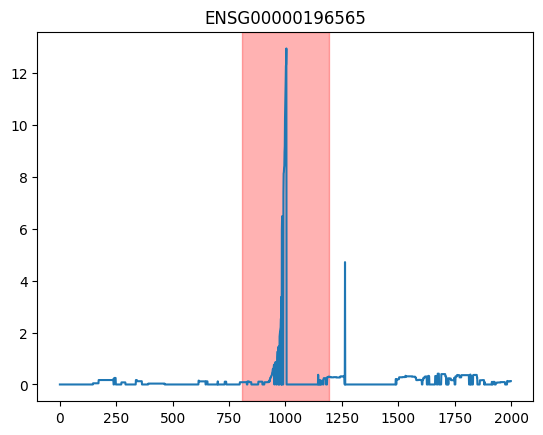

Pred: 1.0657157
Actual: 4.842275


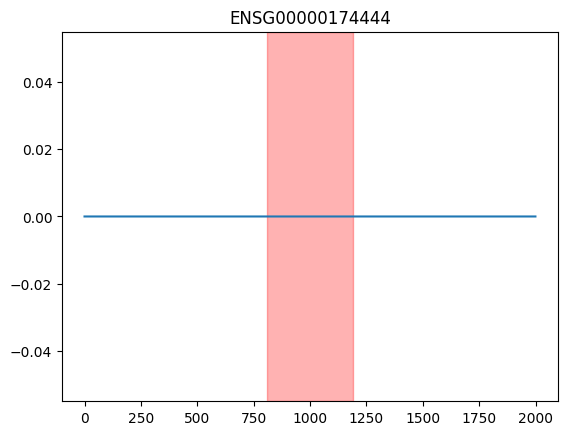

Pred: 1.2063757
Actual: 4.4754343


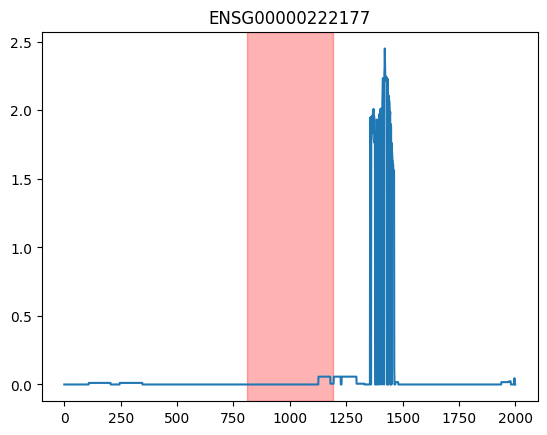

Pred: 0.05833839
Actual: 3.251373


In [117]:
# Individual Plots
signal_5_worst_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_under_gm):
    plt.plot(signal_5_worst_under_gm[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.show()

    print(f"Pred: {gm[gm["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {gm[gm["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_under_k5):
    plt.plot(signal_5_worst_under_k5[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.show()

    print(f"Pred: {k5[k5["Unnamed: 0"] == v.decode()]["Pred"].iloc[0]}")
    print(f"Actual: {k5[k5["Unnamed: 0"] == v.decode()]["actual"].iloc[0]}")

Zero Signal (Actual)

GM12878: 
Threshold: 0
Genes per Fold: 
1: 981
2: 822
3: 710
4: 617
5: 783
6: 649
7: 652
8: 815
9: 805
10: 909
11: 618
12: 719
Total Number of Matches: 9080
Total Matches with >= 1 Non-Zero Value: 4136
Percentage of TSSs with No Signal: 54.45%
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000237330', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000078808', 'ENSG00000169972', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000107404', 'ENSG00000221978', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000272106', 'ENSG00000197530_1', 'ENSG00000197530_2', 'ENSG00000189409', 'ENSG00000248333', 'ENSG00000178821', 'ENSG00000142609_1',

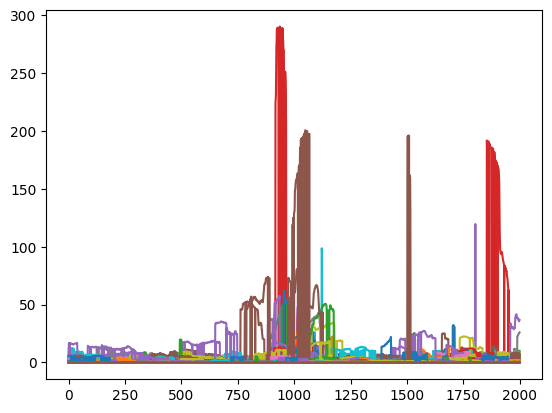

K562: 
Threshold: 0
Genes per Fold: 
1: 1253
2: 1155
3: 928
4: 772
5: 1085
6: 846
7: 862
8: 1108
9: 1116
10: 1237
11: 843
12: 1040
Total Number of Matches: 12245
Total Matches with >= 1 Non-Zero Value: 5189
Percentage of TSSs with No Signal: 57.62%
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188157', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000186891', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000162576', 'ENSG00000175756', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000179403', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000197530', 'ENSG00000272106', 'ENSG00000197530_2', 'ENSG00000189409', 'ENSG00000078369_1', 'ENSG00000169885', 'ENSG00000178821', 

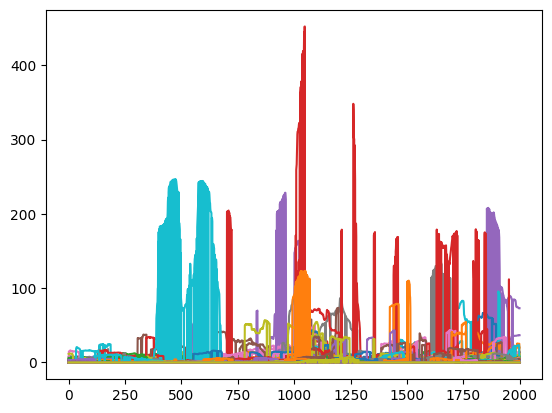

<Figure size 640x480 with 0 Axes>

In [118]:
print("GM12878: ")
gm_no_signal_actual = test_thresholds(gm, gm_h5, "actual", [0], "eq")

print("K562: ")
k5_no_signal_actual = test_thresholds(k5, k5_h5, "actual", [0], "eq")